In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive





Kaggle Username: crispyfriedchicken



First, read the dataset from the CSV file and move it to a DataFrame.



In [2]:
import pandas as pd
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

## Install and Import Libraries

In this section, I'll install FastText, a word embedding technique that is particularly beneficial for content-based filtering tasks. FastText excels in capturing semantic meanings and contextual information from text data by representing words as dense vectors in a continuous vector space. I also install scikit-surprise for building and evaluating recommendation systems.

In [3]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227139 sha256=48463507bd0c41277e48c473daeeeec66b16cbea22403aeedc3a51854da9e16c
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [4]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357247 sha256=2cf1d62cd406ccd157f8bde409941fa7df9ee22ee9cf73e764c4aff86a88e57f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [5]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import torch
from transformers import BertModel, BertTokenizer
from surprise import Dataset, Reader, KNNBasic, accuracy,SVD
from surprise.model_selection import train_test_split, GridSearchCV,cross_validate
import gc
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import cross_validate
import pickle
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel
from math import sqrt


<ipython-input-6-01c3964a3b85>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## EDA

In this section, I analyse the problem in the dataset. I plot the distribution of ratings to determine whether the dataset is skewed and assess its usefulness for designing a recommender system that can handle the data effectively. Additionally, I plot the proportion of new items in the test dataset to identify whether a cold start problem occurs. The cold start phenomenon happens when there are new products that do not appear in the training dataset.

### Distribution of Ratings in Train Data

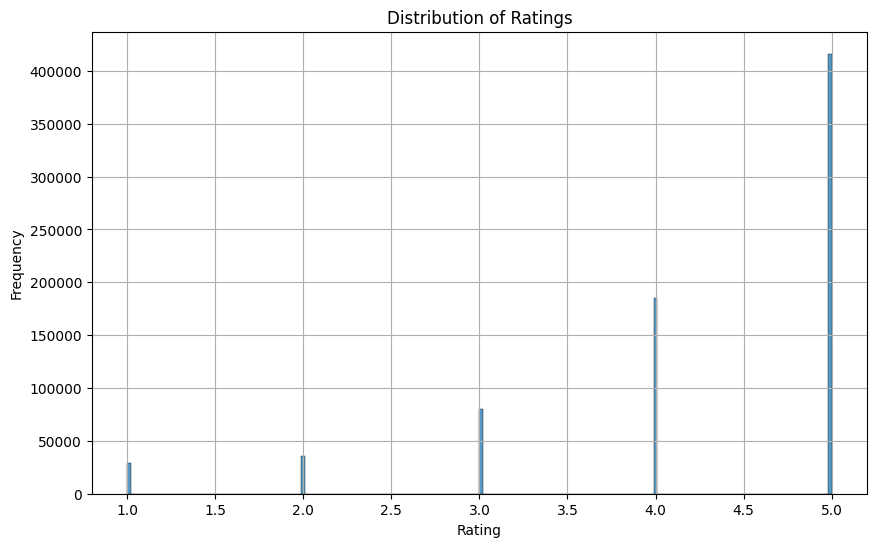

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Proportion of New vs. Existing Products in Test Set

Number of new products in the test set: 16673


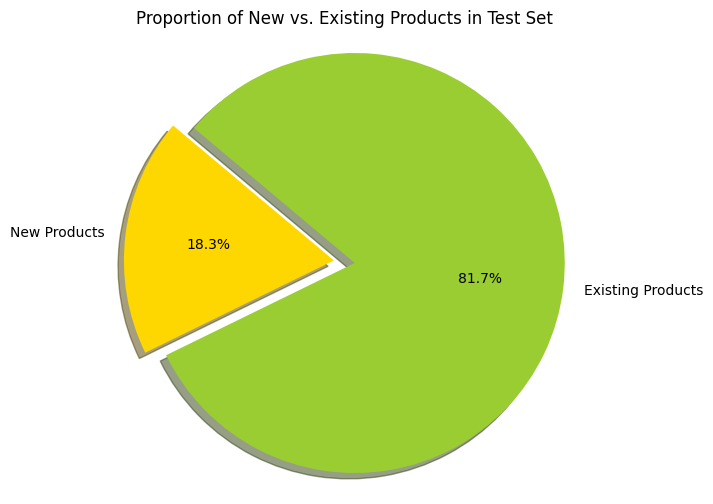

In [ ]:
train_products = set(train_data['product_name'])
test_products = set(test_data['product_name'])

# Identify new products that are in the test set but not in the training set
new_products = test_products - train_products
num_new_products = len(new_products)
print("Number of new products in the test set:", num_new_products)
import matplotlib.pyplot as plt

# Data to plot
labels = 'New Products', 'Existing Products'
sizes = [len(new_products), len(test_products - new_products)]

# Colors
colors = ['gold', 'yellowgreen']

explode = (0.1, 0)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Proportion of New vs. Existing Products in Test Set')
plt.show()


## Content Based Filtering


In this section, I try three word embeddings to compute content-based filtering: FastText, Word2Vec, and BERT. I use product names to search for similarities, which will be useful for new products. By finding the similarity of the new product, the system can reference ratings for the new item. Based on this analysis, I choose Word2Vec as the best embedding to be combined in the hybrid approach.

### Fast Text

In [ ]:
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to compute FastText embeddings
def get_fasttext_embedding(text, model):
    # Retrieve the sentence vector for a given text from the FastText model
    return model.get_sentence_vector(text)

# Splitting the dataset into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

def train_and_evaluate(train_data, save_model_path, K=10, relevance_threshold=4):
    # Save the training data to a temporary text file for FastText training
    temp_train_file = "temp_train.txt"
    with open(temp_train_file, 'w', encoding='utf-8') as file:
        for index, row in train_data.iterrows():
            label = "__label__" + str(row['rating'])  # Example label format
            text = row['product_name'].replace('\n', ' ')  # Ensure no newlines in text
            file.write(f"{label} {text}\n")

    # Train a FastText supervised model on the training data
    model = fasttext.train_supervised(input=temp_train_file, lr=0.1, epoch=25, wordNgrams=2, verbose=2)
    model.save_model(save_model_path)

    # Compute FastText embeddings for the product names in the training data
    train_embeddings = [model.get_sentence_vector(text) for text in train_data['product_name']]

    # Initialize lists to store metrics and data for later comparison
    actual_ratings = []
    predicted_ratings = []
    item_indices = []

    # Iterate over validation data in batches to compute predictions
    batch_size = 100
    for i in range(0, len(val_data), batch_size):
        val_batch = val_data.iloc[i:i+batch_size]
        val_embeddings_batch = [model.get_sentence_vector(text) for text in val_batch['product_name']]
        similarity_matrix_batch = cosine_similarity(val_embeddings_batch, train_embeddings)

        for j in range(len(val_batch)):
            similarity_scores = similarity_matrix_batch[j]
            train_ratings = train_data['rating'].values
            weighted_sum = np.sum(similarity_scores * train_ratings)
            total_similarity = np.sum(similarity_scores)
            predicted_rating = weighted_sum / total_similarity if total_similarity != 0 else 0

            actual_ratings.append(val_batch.iloc[j]['rating'])
            predicted_ratings.append(predicted_rating)
            item_indices.append(val_batch.index[j])

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    # Prepare for Precision@K and Recall@K calculations
    predictions_df = pd.DataFrame({
        'item_index': item_indices,
        'predicted_rating': predicted_ratings,
        'actual_rating': actual_ratings
    }).sort_values(by='predicted_rating', ascending=False)

    top_k_predictions = predictions_df.head(K)
    relevant_items = predictions_df[predictions_df['actual_rating'] >= relevance_threshold]
    relevant_top_k = top_k_predictions[top_k_predictions['actual_rating'] >= relevance_threshold]

    precision_at_k = len(relevant_top_k) / K
    recall_at_k = len(relevant_top_k) / len(relevant_items) if len(relevant_items) > 0 else 0

    return {
        'RMSE': rmse,
        'MAE': mae,
        'Precision@K': precision_at_k,
        'Recall@K': recall_at_k
    }

# Ensure you are using the correct model loading given the fastText update
def load_and_compute_embeddings(train_data):
    model = fasttext.load_model('fasttext_model.bin')
    return {product_name: get_fasttext_embedding(product_name, model) for product_name in train_data['product_name'].unique()}

product_embeddings = load_and_compute_embeddings(train_data)

# Compute user profiles and predict ratings
def compute_user_profile(user_id, data, product_embeddings):
    user_ratings = data[data['user_id'] == user_id]
    weighted_embeddings = [
        product_embeddings[row['product_name']] * row['rating']
        for index, row in user_ratings.iterrows()
        if row['product_name'] in product_embeddings
    ]
    return np.mean(weighted_embeddings, axis=0) if weighted_embeddings else np.zeros(len(next(iter(product_embeddings.values()))))

user_profiles = {user: compute_user_profile(user, train_data, product_embeddings) for user in train_data['user_id'].unique()}

def predict_rating(user_id, product_name, user_profiles, product_embeddings):
    user_profile = user_profiles.get(user_id, np.zeros(len(next(iter(product_embeddings.values())))))
    product_embedding = product_embeddings.get(product_name, np.zeros(len(next(iter(product_embeddings.values())))))
    return cosine_similarity([user_profile], [product_embedding])[0][0]

val_data['similarity'] = val_data.apply(lambda row: predict_rating(row['user_id'], row['product_name'], user_profiles, product_embeddings), axis=1)

# Print evaluation metrics
batch_metrics = train_and_evaluate(train_data, 'fasttext_model.bin', K=10)
print("RMSE:", batch_metrics['RMSE'])
print("MAE:", batch_metrics['MAE'])
print("Precision@K:", batch_metrics['Precision@K'])
print("Recall@K:", batch_metrics['Recall@K'])


RMSE: 6.323555161327972
MAE: 0.9146780973421937
Precision@K: 0.5
Recall@K: 5.19367202999865e-05


### Word2Vec

In [ ]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Train Word2Vec model
product_names = train_data['product_name'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=product_names, vector_size=300, window=5, min_count=1, workers=4)

# Compute embeddings for products
def compute_product_embedding(product_name, model):
    words = product_name.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

product_embeddings = {product: compute_product_embedding(product, word2vec_model) for product in train_data['product_name'].unique()}


In [ ]:
def compute_user_profile(user_id, data, product_embeddings):
    # Extract user ratings from the data
    user_ratings = data[data['user_id'] == user_id]

    # Compute weighted embeddings for the user's interactions
    weighted_embeddings = [product_embeddings[row['product_name']] * row['rating'] for index, row in user_ratings.iterrows()]

    # Compute the mean of the weighted embeddings if there are interactions, else return zeros
    return np.mean(weighted_embeddings, axis=0) if weighted_embeddings else np.zeros(word2vec_model.vector_size)

# Compute user profiles for all unique users in the training data
user_profiles = {user: compute_user_profile(user, train_data, product_embeddings) for user in train_data['user_id'].unique()}

def predict_rating(user_id, product_name, user_profiles, product_embeddings):
    # Retrieve user profile and product embedding
    user_profile = user_profiles.get(user_id, np.zeros(word2vec_model.vector_size))
    product_embedding = product_embeddings.get(product_name, np.zeros(word2vec_model.vector_size))

    # Compute cosine similarity between user profile and product embedding
    return cosine_similarity([user_profile], [product_embedding])[0][0]

# Apply predict_rating function to each row in the validation data to compute similarity
val_data['similarity'] = val_data.apply(lambda row: predict_rating(row['user_id'], row['product_name'], user_profiles, product_embeddings), axis=1)


In [ ]:
scaler = MinMaxScaler(feature_range=(1, 5))
val_data['predicted_rating'] = scaler.fit_transform(val_data[['similarity']])

# Calculate evaluation metrics
actual_ratings = val_data['rating']
predicted_ratings = val_data['predicted_rating']
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
mae = mean_absolute_error(actual_ratings, predicted_ratings)

# Calculate Precision@K and Recall@K
K = 10
predictions_df = val_data[['rating', 'predicted_rating']].sort_values(by='predicted_rating', ascending=False)
top_k_predictions = predictions_df.head(K)
relevant_items = predictions_df[predictions_df['rating'] >= 4]
relevant_top_k = top_k_predictions[top_k_predictions['rating'] >= 4]

precision_at_k = len(relevant_top_k) / K
recall_at_k = len(relevant_top_k) / len(relevant_items) if len(relevant_items) > 0 else 0

# Compile results
results = {
    'RMSE': rmse,
    'MAE': mae,
    'Precision@K': precision_at_k,
    'Recall@K': recall_at_k
}

print("RMSE:", results['RMSE'])
print("MAE:", results['MAE'])
print("Precision@K:", results['Precision@K'])
print("Recall@K:", results['Recall@K'])



RMSE: 1.5695634976055703
MAE: 1.2727559875821262
Precision@K: 0.9
Recall@K: 0.000116910446597906


### BERT

In [ ]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize model
model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def compute_bert_embedding_batch(products):
    # Tokenize the input products
    encoded_input = tokenizer(products, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        # Pass the encoded input through the BERT model
        output = model(**encoded_input)

    # Compute the mean of the last hidden state across tokens for each product
    return output.last_hidden_state.mean(dim=1)


In [ ]:
# Load and split data
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Compute product embeddings for training data
products = train_data['product_name'].unique().tolist()
batch_size = 100
product_embeddings = {}
for i in range(0, len(products), batch_size):
    batch = products[i:i+batch_size]
    embeddings = compute_bert_embedding_batch(batch).numpy()
    for j, product in enumerate(batch):
        product_embeddings[product] = embeddings[j]

# Compute user profile embeddings
def compute_user_profile(user_id, data):
    user_ratings = data[data['user_id'] == user_id]
    weighted_embeddings = [product_embeddings[row['product_name']] * row['rating'] for _, row in user_ratings.iterrows() if row['product_name'] in product_embeddings]
    return np.mean(weighted_embeddings, axis=0) if weighted_embeddings else np.zeros(model.config.hidden_size)

user_profiles = {user: compute_user_profile(user, train_data) for user in train_data['user_id'].unique()}


In [ ]:
def predict_rating(user_id, product_name):
    # Get user profile (default to zeros if not found) and product embedding (default to zeros if not found)
    user_profile = user_profiles.get(user_id, np.zeros(model.config.hidden_size))
    product_embedding = product_embeddings.get(product_name, np.zeros(model.config.hidden_size))

    # Calculate cosine similarity between user profile and product embedding
    similarity = cosine_similarity([user_profile], [product_embedding])[0][0]

    # Rescale similarity to predicted rating range (1 to 5) using Min-Max scaling
    return similarity

# Apply predict_rating function to each row in the validation data to compute similarity
val_data['similarity'] = val_data.apply(lambda row: predict_rating(row['user_id'], row['product_name']), axis=1)

# Scale similarity scores to the range of predicted ratings (1 to 5) using Min-Max scaling
scaler = MinMaxScaler(feature_range=(1, 5))
val_data['predicted_rating'] = scaler.fit_transform(val_data[['similarity']].values.reshape(-1, 1))


In [ ]:
actual_ratings = val_data['rating']
predicted_ratings = val_data['predicted_rating']
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
mae = mean_absolute_error(actual_ratings, predicted_ratings)

# Define K and compute Precision@K and Recall@K
K = 10
predictions_df = val_data[['rating', 'predicted_rating']].sort_values(by='predicted_rating', ascending=False)
top_k_predictions = predictions_df.head(K)
relevant_items = predictions_df[predictions_df['rating'] >= 4]
relevant_top_k = top_k_predictions[top_k_predictions['rating'] >= 4]

precision_at_k = len(relevant_top_k) / K
recall_at_k = len(relevant_top_k) / len(relevant_items) if len(relevant_items) > 0 else 0

# Compile results
results = {
    'RMSE': rmse,
    'MAE': mae,
    'Precision@K': precision_at_k,
    'Recall@K': recall_at_k
}

print("RMSE:", results['RMSE'])
print("MAE:", results['MAE'])
print("Precision@K:", results['Precision@K'])
print("Recall@K:", results['Recall@K'])


RMSE: 1.9178004259039902
MAE: 1.4010473490648736
Precision@K: 0.8
Recall@K: 0.00013006226731047488


## Collaborative Based Filtering

In this section, I try three approaches to compute collaborative-based filtering: SVD,KNN and Neural Network. Based on the result, I choose SVD and Neural Network  as the best collaborative filtering techniques to be combined in the hybrid approach.

### SVD

In [7]:
reader = Reader(rating_scale=(1, 5))

# Load data from DataFrame
data = Dataset.load_from_df(train_data[['user_id', 'product_name', 'rating']], reader)

# Define range of minimum interactions to test
min_interactions_range = [3, 5, 10, 20]
best_rmse = float('inf')
optimal_min_interactions = 0

# Iterate over each minimum interaction threshold
for min_interactions in min_interactions_range:
    # Build the full trainset from data
    full_trainset = data.build_full_trainset()
    # Count interactions per user
    user_interactions_count = {uid: len(full_trainset.ur[uid]) for uid in full_trainset.all_users()}
    # Filter users who meet the minimum interaction threshold
    filtered_users = [uid for uid, counts in user_interactions_count.items() if counts >= min_interactions]

    # Create filtered DataFrame based on the users
    filtered_data = train_data[train_data['user_id'].isin(filtered_users)]
    if filtered_data.empty:
        print(f"No data for min_interactions = {min_interactions}. Skipping...")
        continue

    # Load filtered data into Surprise dataset
    filtered_dataset = Dataset.load_from_df(filtered_data[['user_id', 'product_name', 'rating']], reader)
    # Initialize SVD algorithm
    svd = SVD()
    # Perform cross-validation
    results = cross_validate(svd, filtered_dataset, measures=['RMSE'], cv=3, verbose=False)
    # Calculate average RMSE
    avg_rmse = sum(results['test_rmse']) / len(results['test_rmse'])

    print(f"Testing min_interactions = {min_interactions}: Average RMSE = {avg_rmse}")
    # Update best RMSE and optimal minimum interactions if current RMSE is better
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        optimal_min_interactions = min_interactions

# Output the optimal number of interactions and corresponding RMSE
print(f"Optimal min_interactions: {optimal_min_interactions} with RMSE: {best_rmse}")


Testing min_interactions = 3: Average RMSE = 0.8847115869640815
Testing min_interactions = 5: Average RMSE = 0.8844396715501098
Testing min_interactions = 10: Average RMSE = 0.8845233938746002
Testing min_interactions = 20: Average RMSE = 0.8834911614316766
Optimal min_interactions: 20 with RMSE: 0.8834911614316766


In [8]:
# Filter the data to include only users with a minimum number of interactions
user_interaction_counts = train_data['user_id'].value_counts()
filtered_data = train_data[train_data['user_id'].isin([uid for uid, counts in user_interaction_counts.items() if counts >= optimal_min_interactions])]
filtered_dataset = Dataset.load_from_df(filtered_data[['user_id', 'product_name', 'rating']], reader)

model_filename = 'best_svd_model.pkl'
params_filename = 'best_svd_params.pkl'

# Check if the model file already exists
if os.path.exists(model_filename):
    with open(model_filename, 'rb') as file:
        best_svd_model = pickle.load(file)
    with open(params_filename, 'rb') as file:
        best_params = pickle.load(file)
    print(f"Loaded model from {model_filename}")
    print(f"Model parameters: {best_params}")
else:

    param_grid = {
        'n_factors': [50, 100, 150],  # Number of latent factors
        'n_epochs': [20, 30, 40],     # Number of iterations of the SGD procedure
        'lr_all': [0.005, 0.01],      # Learning rate
        'reg_all': [0.02, 0.1]        # Regularization term for all parameters
    }
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(filtered_dataset)

    # Get the best parameters and train the final model
    best_params = gs.best_params['rmse']
    trainset = filtered_dataset.build_full_trainset()
    best_svd_model = SVD(**best_params)
    best_svd_model.fit(trainset)

    # Save the model and the parameters to files
    with open(model_filename, 'wb') as file:
        pickle.dump(best_svd_model, file)
    with open(params_filename, 'wb') as file:
        pickle.dump(best_params, file)

    print(f"Model saved to {model_filename}")
    print(f"Model parameters saved: {best_params}")


Model saved to best_svd_model.pkl
Model parameters saved: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}


In [9]:
# Splitting the filtered dataset
trainset, valset = train_test_split(filtered_dataset, test_size=0.2)

# Fit the best model on the trainset
best_svd_model = SVD(**best_params)
best_svd_model.fit(trainset)

# Predicting and evaluating the model on the validation set
predictions = best_svd_model.test(valset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")

RMSE: 0.8144
MAE:  0.5466
Validation RMSE: 0.814412210645889
Validation MAE: 0.5465990130164391


In the code below, I evaluate the learning rate of the SVD algorithm in collaborative filtering on data that has at least a minimum number of interactions. This data does not include new products or new users.

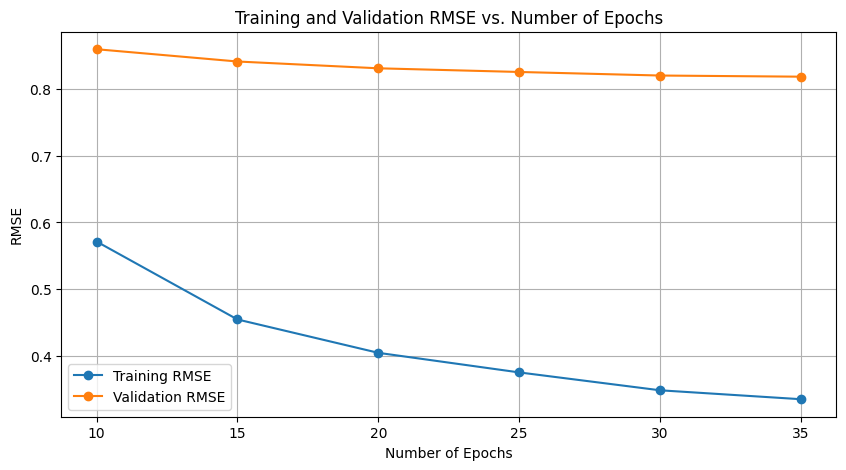

In [10]:
user_counts = train_data['user_id'].value_counts()
# Filter users with optimal min interactions
filtered_data = train_data[train_data['user_id'].isin(user_counts[user_counts >= optimal_min_interactions].index)]

# Load filtered data into surprise
data = Dataset.load_from_df(filtered_data[['user_id', 'product_name', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define epochs, learning rate, regularization, and number of factors ( Based on Hyper Parameter Tuning Result)
epochs = range(10, 40, 5)
learning_rate = 0.01
reg_all = 0.02
n_factors = 150

train_rmse_results = []
test_rmse_results = []

# Train and evaluate the model over varying number of epochs
for epoch in epochs:
    model = SVD(n_epochs=epoch, lr_all=learning_rate, reg_all=reg_all, n_factors=n_factors)
    model.fit(trainset)

    # Test on the training set
    train_predictions = model.test(trainset.build_testset())
    train_rmse = accuracy.rmse(train_predictions, verbose=False)
    train_rmse_results.append(train_rmse)

    # Test on the test set
    test_predictions = model.test(testset)
    test_rmse = accuracy.rmse(test_predictions, verbose=False)
    test_rmse_results.append(test_rmse)

# Plotting the RMSE vs. Epochs for both training and testing sets
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_rmse_results, marker='o', label='Training RMSE')
plt.plot(epochs, test_rmse_results, marker='o', label='Validation RMSE')
plt.title('Training and Validation RMSE vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


### KNN

In [ ]:
reader = Reader(rating_scale=(1, 5))

# Filter the data based on the optimal minimum interactions
user_interaction_counts = train_data['user_id'].value_counts()
filtered_data = train_data[train_data['user_id'].isin(user_interaction_counts[user_interaction_counts >= optimal_min_interactions].index)]
data = Dataset.load_from_df(filtered_data[['user_id', 'product_name', 'rating']], reader)
trainset, valset = train_test_split(data, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'k': [10, 20, 30],  # Number of neighbors
    'min_k': [1, 3, 5]  # Minimum number of neighbors
}

model_filename = 'best_knn_model.pkl'

# Check if the model already exists
if os.path.exists(model_filename):
    with open(model_filename, 'rb') as file:
        best_knn_model = pickle.load(file)
    print(f"Loaded model from {model_filename}")
else:
    # Perform grid search
    gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)

    # Best model parameters
    best_params = gs.best_params['rmse']
    print("Best parameters:", best_params)

    # Train the final model using best parameters on the entire training set
    best_knn_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'])
    best_knn_model.fit(trainset)

    # Save the model to a file
    with open(model_filename, 'wb') as file:
        pickle.dump(best_knn_model, file)
    print(f"Model saved to {model_filename}")

# Evaluate the model on the validation set
predictions = best_knn_model.test(valset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f'RMSE: {rmse}, MAE: {mae}')

# Cleanup
gc.collect()


Loaded model from best_knn_model.pkl
RMSE: 0.7339
MAE:  0.4910
RMSE: 0.7338560330666717, MAE: 0.4910252148282829


0

Computing the cosine similarity matrix...
Done computing similarity matrix.
Training RMSE: 0.9367614627542047
Validation RMSE: 1.0413928641414711


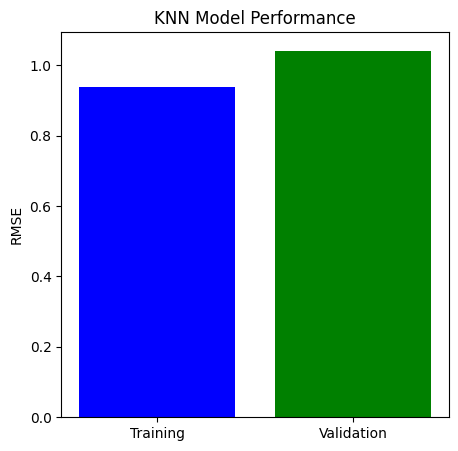

In [ ]:
reader = Reader(rating_scale=(1, 5))
user_counts = train_data['user_id'].value_counts()
filtered_data = train_data[train_data['user_id'].isin(user_counts[user_counts >= 3].index)]
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

data = Dataset.load_from_df(filtered_data[['user_id', 'product_name', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# KNN parameters
k = 10
min_k = 3

# Train KNN model
model = KNNBasic(k=k, min_k=min_k, sim_options={'name': 'cosine', 'user_based': True})
model.fit(trainset)

# Evaluate the model on a given dataset and return RMSE
def evaluate_model(model, testset):
    predictions = model.test(testset)
    return accuracy.rmse(predictions, verbose=False)

# Store RMSE results
train_rmse = evaluate_model(model, trainset.build_testset())
test_rmse = evaluate_model(model, testset)

# Output results
print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {test_rmse}")

# Plot The Figure
plt.figure(figsize=(5, 5))
plt.bar(['Training', 'Validation'], [train_rmse, test_rmse], color=['blue', 'green'])
plt.title('KNN Model Performance')
plt.ylabel('RMSE')
plt.show()


### Neural Network

In [ ]:
from sklearn.model_selection import train_test_split

# Function to compute a product embedding from its name using Word2Vec.
# It also concatenates additional features like helpful_votes and votes to the embedding.
def compute_product_embedding(row, model):
    # Split product name into individual words
    words = row['product_name'].split()
    # Retrieve the Word2Vec embedding for each word if it exists in the model's vocabulary
    word_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]
    # Average the embeddings to get a single representation for the product
    if word_vectors:
        embedding = np.mean(word_vectors, axis=0)
    else:
        # Use a zero vector if the product name contains no words found in the Word2Vec model
        embedding = np.zeros(model.vector_size)
    # Return the final product embedding with votes and helpful votes appended
    return np.concatenate([embedding, [row['helpful_votes'], row['votes']]])

# Function to compute embeddings for all products in batches to manage memory usage efficiently.
def compute_embeddings_in_batches(data, model, batch_size=100):
    product_embeddings = {}
    # Iterate through the data in batches
    for start in range(0, data.shape[0], batch_size):
        end = start + batch_size
        batch = data.iloc[start:end]
        # Compute and store the embedding for each product in the batch
        for _, row in batch.iterrows():
            product_embeddings[row['product_name']] = compute_product_embedding(row, model)
    return product_embeddings

# Function to compute user profiles based on the product embeddings they have interacted with,
# weighted by their ratings, and done in batches.
def compute_user_profiles_in_batches(data, product_embeddings, word2vec_size, batch_size=100):
    user_profiles = {}
    # Get unique user IDs to process in batches
    users = data['user_id'].unique()
    for start in range(0, len(users), batch_size):
        end = start + batch_size
        user_batch = users[start:end]
        # Compute each user's profile as the mean of their rated product embeddings
        for user in user_batch:
            user_ratings = data[data['user_id'] == user]
            weighted_embeddings = []
            for _, row in user_ratings.iterrows():
                # Use precomputed product embeddings or a zero vector if not available
                product_embedding = product_embeddings.get(row['product_name'], np.zeros(word2vec_size + 2))
                weighted_embedding = product_embedding * row['rating']
                weighted_embeddings.append(weighted_embedding)
            # Average the embeddings to form the user profile
            if weighted_embeddings:
                user_profiles[user] = np.mean(weighted_embeddings, axis=0)
            else:
                user_profiles[user] = np.zeros(word2vec_size + 2)
    return user_profiles

# Split the data into training and validation sets
trainset, valset = train_test_split(train_data, test_size=0.2, random_state=42)

# Train a Word2Vec model on unique product names
sentences = [name.split() for name in train_data['product_name'].unique()]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Compute product embeddings using the trained Word2Vec model
product_embeddings = compute_embeddings_in_batches(train_data, word2vec_model, batch_size=100)

# Compute user profiles using the computed product embeddings
user_profiles = compute_user_profiles_in_batches(train_data, product_embeddings, word2vec_model.vector_size, batch_size=100)


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class NeuralCollaborativeFilteringHyperModel(HyperModel):
    def __init__(self, num_users, num_items):
        # Initialize with number of users and items
        self.num_users = num_users
        self.num_items = num_items

    def build(self, hp):
        # Define model inputs
        user_input = Input(shape=(1,))
        item_input = Input(shape=(1,))
        votes_input = Input(shape=(1,))
        helpful_votes_input = Input(shape=(1,))

        embedding_size = hp.Int('embedding_size', min_value=50, max_value=100, step=20)
        user_embedding = Embedding(input_dim=self.num_users + 1, output_dim=embedding_size)(user_input)
        item_embedding = Embedding(input_dim=self.num_items + 1, output_dim=embedding_size)(item_input)

        # Flatten embeddings
        user_vector = Flatten()(user_embedding)
        item_vector = Flatten()(item_embedding)

        # Concatenate user and item vectors with additional inputs
        concat = Concatenate()([user_vector, item_vector, votes_input, helpful_votes_input])

        # Define dense layer size as a hyperparameter
        dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
        dense = Dense(dense_units, activation='relu')(concat)

        # Define dropout rate as a hyperparameter
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        dropout = Dropout(dropout_rate)(dense)

        # Second dense layer with half the size of the first
        dense = Dense(dense_units // 2, activation='relu')(dropout)

        # Output layer for predicting the rating
        output = Dense(1, activation='linear')(dense)

        # Compile model
        model = Model(inputs=[user_input, item_input, votes_input, helpful_votes_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

# Prepare dataset
num_users = train_data['user_id'].max() + 1
num_items = train_data['product_id'].max() + 1

# Prepare training and validation data arrays
user_ids = trainset['user_id'].values
product_ids = trainset['product_id'].values
votes = trainset['votes'].values
helpful_votes = trainset['helpful_votes'].values
ratings = trainset['rating'].values

val_user_ids = valset['user_id'].values
val_product_ids = valset['product_id'].values
val_votes = valset['votes'].values
val_helpful_votes = valset['helpful_votes'].values
val_ratings = valset['rating'].values

# Path to save the best model
model_path = 'neural.h5'
if os.path.exists(model_path):
    # Load the best model if it already exists
    best_model = load_model(model_path)
else:
    # Create a hypermodel instance
    hypermodel = NeuralCollaborativeFilteringHyperModel(num_users=num_users, num_items=num_items)
    # Set up the tuner
    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='my_dir',
        project_name='ncf'
    )
    # Run the search
    tuner.search(
        [user_ids, product_ids, votes, helpful_votes], ratings,
        validation_data=([val_user_ids, val_product_ids, val_votes, val_helpful_votes], val_ratings),
        epochs=10,
        batch_size=32
    )

    # Get and save the best model from the tuner
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.save(model_path)

# Print model summary
best_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 70)                140070    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 70)                1246266   ['input_2[0][0]']             
                                                          0                                   

In [ ]:
average_user_ratings = train_data.groupby('user_id')['rating'].mean().to_dict()
global_average_rating = train_data['rating'].mean()

val_data['predicted_rating'] = 0
# Predict ratings for known products
for index, row in val_data.iterrows():
    user_id = row['user_id']
    product_id = row['product_id']
    votes = row['votes']
    helpful_votes = row['helpful_votes']

    if product_id in product_embeddings:
        user_input = np.array([user_id])
        product_input = np.array([product_id])
        votes_input = np.array([votes])
        helpful_votes_input = np.array([helpful_votes])
        # Predict using the model
        predicted_rating = best_model.predict([user_input, product_input, votes_input, helpful_votes_input])
        val_data.at[index, 'predicted_rating'] = predicted_rating.flatten()[0]
    else:
        # Average user rating if the product is unknown
        val_data.at[index, 'predicted_rating'] = average_user_ratings.get(user_id, global_average_rating)
# Handle missing votes and helpful votes if they're not available in val_data
if 'votes' not in val_data:
    val_votes = np.zeros(len(val_user_ids))
    val_votes = val_data['votes'].values

if 'helpful_votes' not in val_data:
    val_helpful_votes = np.zeros(len(val_user_ids))
else:
    val_helpful_votes = val_data['helpful_votes'].values

true_ratings = val_data['rating'].values
predicted_ratings = val_data['predicted_rating'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
# Calculate MAE
mae = mean_absolute_error(true_ratings, predicted_ratings)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)


Root Mean Squared Error: 0.9811855392534777
Mean Absolute Error: 0.7395616639926117


## Hybrid Based Filtering

In this section, I tested two approaches, Word2Vec+SVD .
I evaluate it by using RMSE,MAE in validation and RMSE on Kaggle.

### Word2Vec+SVD

In [11]:
# Function to compute the embedding for a product based on its name.
# Embeddings are computed by averaging the Word2Vec vectors of the words in the product name.
# Additional features, helpful_votes and votes, are concatenated to the final embedding.
def compute_product_embedding(row, model):
    # Split the product name into words
    words = row['product_name'].split()
    # Gather Word2Vec embeddings for words present in the model's vocabulary
    word_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]
    # Calculate the mean of these vectors if any exist, otherwise use a zero vector
    if word_vectors:
        embedding = np.mean(word_vectors, axis=0)
    else:
        embedding = np.zeros(model.vector_size)
    # Return the combined embedding vector, including additional features
    return np.concatenate([embedding, [row['helpful_votes'], row['votes']]])

# Function to compute product embeddings for all products in batches.
def compute_embeddings_in_batches(data, model, batch_size=100):
    product_embeddings = {}
    # Process each batch of products
    for start in range(0, data.shape[0], batch_size):
        end = start + batch_size
        batch = data.iloc[start:end]
        # Compute and store embeddings for each product in the batch
        for _, row in batch.iterrows():
            product_embeddings[row['product_name']] = compute_product_embedding(row, model)
    return product_embeddings

# Function to compute user profiles as the average of weighted product embeddings they've rated,
# in batches.
def compute_user_profiles_in_batches(data, product_embeddings, word2vec_size, batch_size=100):
    user_profiles = {}
    users = data['user_id'].unique()
    # Process each batch of users
    for start in range(0, len(users), batch_size):
        end = start + batch_size
        user_batch = users[start:end]
        # Compute user profiles for each user in the batch
        for user in user_batch:
            user_ratings = data[data['user_id'] == user]
            weighted_embeddings = []
            # Compute weighted product embeddings based on user ratings
            for _, row in user_ratings.iterrows():
                product_embedding = product_embeddings.get(row['product_name'], np.zeros(word2vec_size + 2))
                weighted_embedding = product_embedding * row['rating']
                weighted_embeddings.append(weighted_embedding)
            # Average these weighted embeddings to form the user profile
            if weighted_embeddings:
                user_profiles[user] = np.mean(weighted_embeddings, axis=0)
            else:
                user_profiles[user] = np.zeros(word2vec_size + 2)
    return user_profiles

# Assuming 'Dataset' and 'train_test_split' are from a library such as Surprise
data = Dataset.load_from_df(train_data[['user_id', 'product_name', 'rating']], reader)

# Split data into training and validation sets
trainset, valset = train_test_split(data, test_size=0.2, random_state=42)

# Train a Word2Vec model on product names
sentences = [name.split() for name in train_data['product_name'].unique()]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Compute embeddings for products
product_embeddings = compute_embeddings_in_batches(train_data, word2vec_model, batch_size=100)

# Compute user profiles
user_profiles = compute_user_profiles_in_batches(train_data, product_embeddings, word2vec_model.vector_size, batch_size=100)


In [12]:
# Function to predict ratings using a combination of SVD model predictions and similarity-based predictions.
# It switches methods based on the number of user interactions.
def batch_switching_predict(user_ids, product_names, svd_model, user_profiles, product_embeddings, avg_rating, data, min_interactions):
    predictions = []
    for user_id, product_name in zip(user_ids, product_names):
        # Count the number of interactions for the user
        user_interactions = data[data['user_id'] == user_id].shape[0]
        if user_interactions >= min_interactions:
            try:
                # Try to predict using the SVD model
                prediction = svd_model.predict(user_id, product_name).est
            except:
                # If SVD model fails, use average user rating if available, otherwise use global average
                user_ratings = data[data['user_id'] == user_id]['rating']
                if not user_ratings.empty:
                    prediction = user_ratings.mean()
                else:
                    prediction = avg_rating
        else:
            # For users with few interactions, use similarity-based predictions
            prediction = predict_similarity_rating(user_id, product_name, user_profiles, product_embeddings, avg_rating, data)
        predictions.append(prediction)
    return predictions

# Function to predict ratings based on product similarity, using user profiles or global average.
def predict_similarity_rating(user_id, product_name, user_profiles, product_embeddings, avg_rating, train_data):
    if product_name not in product_embeddings:
        # Handle case where product is not in embeddings
        return avg_rating
    target_product_embedding = product_embeddings[product_name]
    if user_id not in user_profiles:
        # Calculate cosine similarities between the target product and all other products
        similarities = cosine_similarity([target_product_embedding], list(product_embeddings.values()))[0]
        product_names = list(product_embeddings.keys())
        weighted_ratings_sum = 0
        similarity_sum = 0
        # Aggregate weighted ratings based on similarity
        for similarity, product in zip(similarities, product_names):
            if product in user_profiles.get(user_id, {}):
                weighted_ratings_sum += similarity * user_profiles[user_id][product]
                similarity_sum += similarity
        if similarity_sum == 0:
            return avg_rating
        return weighted_ratings_sum / similarity_sum
    user_profile = user_profiles[user_id]
    # Similar calculation as above, for known user profiles
    similarities = cosine_similarity([target_product_embedding], list(product_embeddings.values()))[0]
    product_names = list(product_embeddings.keys())
    weighted_ratings_sum = 0
    similarity_sum = 0
    for similarity, product in zip(similarities, product_names):
        if product in user_profile:
            weighted_ratings_sum += similarity * user_profile[product]
            similarity_sum += similarity
    if similarity_sum == 0:
        return avg_rating
    return weighted_ratings_sum / similarity_sum

# Compute the average rating from the training data
avg_rating = train_data['rating'].mean()

# Prepare validation data from the validation set
valset_df = pd.DataFrame(valset, columns=['user_id', 'product_name', 'rating'])

# Extract user IDs and product names for the prediction
val_user_ids = valset_df['user_id'].tolist()
val_product_names = valset_df['product_name'].tolist()

# Use the batch switching method to predict ratings for the validation set
val_predictions = batch_switching_predict(val_user_ids, val_product_names, best_svd_model, user_profiles, product_embeddings, avg_rating, train_data, optimal_min_interactions)

# Append the predictions to the validation DataFrame
valset_df['predicted_rating'] = val_predictions

# Calculate RMSE and MAE for validation
actual = valset_df['rating'].tolist()
predicted = valset_df['predicted_rating'].tolist()
rmse_val = sqrt(mean_squared_error(actual, predicted))
mae_val = mean_absolute_error(actual, predicted)

# Print RMSE and MAE values
print(f'Validation RMSE: {rmse_val}, Validation MAE: {mae_val}')


Validation RMSE: 0.46068627680699276, Validation MAE: 0.24001974363945588


In [ ]:
predictions = batch_switching_predict(test_data['user_id'], test_data['product_name'], best_svd_model, user_profiles, product_embeddings, avg_rating, train_data,optimal_min_interactions)

# Update test_data with predictions
test_data['rating'] = predictions

# Write predictions to CSV
test_data[['ID', 'rating']].to_csv('predicted_ratings_svd.csv', index=False)

# Clear unused variables and collect garbage
del product_embeddings, user_profiles, word2vec_model, best_svd_model, trainset, data
gc.collect()